### COMP 351 Final Project - Toxic Comment Detection

##### Cameron McNamara, Bilal Adam, & Santiago Guerrero

https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

# 1 - Installation + Setup

In [ ]:
!pip install gensim transformers tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 95.7 MB/s eta 0:00:00


In [ ]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Classical ML Models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Dropout, LSTM

from gensim.models import Word2Vec, KeyedVectors

# Transformer Models (BERT)
from transformers import BertTokenizer, TFBertModel, BertForSequenceClassification
from transformers import pipeline

#LLM (Llama)


import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------------------------

# 2 - Dataset Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/COMP351_Final_Project'

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(f'{project_path}/train.csv')


from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    train_df,
    test_size=0.2,     # 20% goes to temp
    random_state=42,
    stratify=train_df['toxic']  # or stratify on any toxic indicator label
)


# ---------------------------------------------------------------------------------

# 3 -  Pre-Processing/Cleaning

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import spacy

In [ ]:
## NLP Packages from Spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
##Remove NA, Dataset Should be clean, but for sanity sake
train_df = train_df.dropna(subset=["comment_text"])
train_df = train_df.drop_duplicates(subset=["comment_text"])
train_df.reset_index(drop=True, inplace=True)

In [ ]:
## Clean Comments
train_df["clean_text"] = train_df["comment_text"].str.lower()
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(r"<.*?>", "", x))
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", " ", x))

#Make sure alphabetic, remove stopwords, remove tiny tokens
train_df["clean_text"] = train_df["clean_text"].apply(
    lambda text: " ".join(
        [
            w for w in text.split()
            if w.isalpha()
            and w not in stop_words
            and len(w) > 1           #
        ]
    )
)


In [ ]:
#this cell is redundant, previous cell does this already

##Filter Out stop words + make sure word is alphabeltical
texts = train_df["clean_text"].tolist()
cleaned_texts = []

for text in texts:
    cleaned = " ".join([
        w for w in text.split()
        if w not in stop_words
        and w.isalpha()
        and len(w) > 1
    ])
    cleaned_texts.append(cleaned)

train_df["clean_text"] = cleaned_texts



# ---------------------------------------------------------------------------------

# 4 - Multi Class Logistic Regresssion

### 4.1 - Train

In [ ]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y = train_df[label_cols].values
train_df["any_toxic"] = train_df[label_cols].max(axis=1)
texts = train_df["clean_text"].values


In [ ]:
X_train_text, X_val_text, y_train, y_val = train_test_split(
    texts,
    y,
    test_size=0.2, ## Validation
    random_state=42,
    stratify=train_df["any_toxic"]
)

In [ ]:
## vectors for TF - IDF models, tokenization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=100_000,   # can tweak
    stop_words='english',
    ngram_range=(1, 2)      # unigrams + bigrams
)

X_train_vec = tfidf.fit_transform(X_train_text)
X_val_vec   = tfidf.transform(X_val_text)

Note: x_train_vec and validation_vec will be used for all TF-IDF models (Logistic Regression and SVM)

In [ ]:
print("y_train shape:", y_train.shape)


y_train shape: (102124, 6)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

base_lr = LogisticRegression(
    max_iter=400,
    C=4.0,
    solver="liblinear")

clf = OneVsRestClassifier(base_lr)
clf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=4.0, max_iter=400,
                                                 solver='liblinear'))

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

# Probabilities
y_val_proba = clf.predict_proba(X_val_vec)

# AUC per label
for i, label in enumerate(label_cols):
    auc = roc_auc_score(y_val[:, i], y_val_proba[:, i])
    print(f"{label}: AUC = {auc:.4f}")

# Turn probs into 0/1 with threshold 0.5
y_val_pred = (y_val_proba > 0.5).astype(int)

print(classification_report(y_val, y_val_pred, target_names=label_cols))

toxic: AUC = 0.9666
severe_toxic: AUC = 0.9824
obscene: AUC = 0.9838
threat: AUC = 0.9860
insult: AUC = 0.9705
identity_hate: AUC = 0.9644
               precision    recall  f1-score   support

        toxic       0.90      0.64      0.75      2433
 severe_toxic       0.46      0.21      0.29       251
      obscene       0.89      0.68      0.77      1344
       threat       0.62      0.18      0.28        71
       insult       0.79      0.54      0.64      1247
identity_hate       0.61      0.27      0.37       222

    micro avg       0.85      0.58      0.69      5568
    macro avg       0.71      0.42      0.52      5568
 weighted avg       0.84      0.58      0.69      5568
  samples avg       0.06      0.05      0.05      5568



### 4.2 - Test

In [ ]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


# merge text + labels
test = test_df

print("pre)", test.shape)
mask = (test[label_cols] != -1).all(axis=1)
test= test[mask]
print("post", test.shape)
# convert -1 → 0 (false), keep 1 as true
test[label_cols] = test[label_cols].replace(-1, 0)

# optional: any_toxic for equal splits
test["any_toxic"] = test[label_cols].max(axis=1)

pre) (31915, 8)
post (31915, 8)


#### Note: test df will be used for rest of models (merge between test.csv and test_labels.csv from dataset

In [ ]:
## Perform Same pre processing steps on test data
test["clean_text"] = test["comment_text"].str.lower()
test["clean_text"] = test["clean_text"].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))
test["clean_text"] = test["clean_text"].apply(lambda x: re.sub(r"<.*?>", "", x))
test["clean_text"] = test["clean_text"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", " ", x))

#Make sure alphabetic, remove stopwords, remove tiny tokens
test["clean_text"] = test["clean_text"].apply(
    lambda text: " ".join(
        [
            w for w in text.split()
            if w.isalpha()
            and w not in stop_words
            and len(w) > 1           #
        ]
    )
)

texts = test["clean_text"].tolist()
cleaned_texts = []

for text in texts:
    cleaned = " ".join([
        w for w in text.split()
        if w not in stop_words
        and w.isalpha()
        and len(w) > 1
    ])
    cleaned_texts.append(cleaned)

test["clean_text"] = cleaned_texts

Note: X_test_vec will be used for all TF-IDF models (Logistic Regression + SVM)

---



In [ ]:
X_test_vec = tfidf.transform(test["clean_text"])
y_test = test[label_cols].values

from sklearn.metrics import roc_auc_score, classification_report

# probability predictions
y_test_proba = clf.predict_proba(X_test_vec)

# AUC per label
for i, label in enumerate(label_cols):
    auc = roc_auc_score(y_test[:, i], y_test_proba[:, i])
    print(f"{label}: Test AUC = {auc:.4f}")

# convert to 0/1 using threshold 0.3
from sklearn.metrics import precision_recall_curve

def best_threshold_prc(y_true, y_proba):
    thresholds = []
    for i in range(y_true.shape[1]):
        precision, recall, th = precision_recall_curve(y_true[:, i], y_proba[:, i])
        f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
        best_idx = f1.argmax()
        thresholds.append(th[best_idx] if best_idx < len(th) else 0.5)
    return np.array(thresholds)

best_thresholds = best_threshold_prc(y_val, y_val_proba)
best_thresholds

y_test_pred = (y_test_proba >= best_thresholds).astype(int)
print(classification_report(y_test, y_test_pred, target_names=label_cols))

toxic: Test AUC = 0.9715
severe_toxic: Test AUC = 0.9814
obscene: Test AUC = 0.9851
threat: Test AUC = 0.9709
insult: Test AUC = 0.9758
identity_hate: Test AUC = 0.9782
               precision    recall  f1-score   support

        toxic       0.79      0.77      0.78      3059
 severe_toxic       0.36      0.64      0.46       311
      obscene       0.79      0.83      0.81      1710
       threat       0.51      0.26      0.34        97
       insult       0.66      0.77      0.71      1590
identity_hate       0.50      0.43      0.46       289

    micro avg       0.72      0.76      0.74      7056
    macro avg       0.60      0.62      0.60      7056
 weighted avg       0.73      0.76      0.74      7056
  samples avg       0.06      0.07      0.06      7056



Results:

- toxic: Test AUC = 0.8874
- severe_toxic: Test AUC = 0.9709
- obscene: Test AUC = 0.9206
- threat: Test AUC = 0.9780
- insult: Test AUC = 0.9161
- identity_hate: Test AUC = 0.9610



# ---------------------------------------------------------------------------------

# 5 - Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

base_svm = LinearSVC()

svm_clf = OneVsRestClassifier(base_svm)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

n_labels = y_train.shape[1]

calibrated_svms = []
probas = []

for i in range(n_labels):
    print(f"Training SVM for label {i+1}/{n_labels} ...")

    base_svm = SGDClassifier(
        loss="hinge",
        alpha=1e-5,
        penalty="l2",
        class_weight="balanced",
        max_iter=5000,
        tol=1e-4
    )

    calibrated = CalibratedClassifierCV(base_svm, method="sigmoid", cv=3)
    calibrated.fit(X_train_vec, y_train[:, i])
    calibrated_svms.append(calibrated)


Training SVM for label 1/6 ...
Training SVM for label 2/6 ...
Training SVM for label 3/6 ...
Training SVM for label 4/6 ...
Training SVM for label 5/6 ...
Training SVM for label 6/6 ...


#### 5.1 - Train

In [ ]:
svm_clf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=LinearSVC())

In [ ]:
y_val_scores = svm_clf.decision_function(X_val_vec)   # shape: (n_val, 6)

print("Validation AUCs (SVM):")
for i, label in enumerate(label_cols):
    auc = roc_auc_score(y_val[:, i], y_val_scores[:, i])
    print(f"{label}: Val AUC = {auc:.4f}")

Validation AUCs (SVM):
toxic: Val AUC = 0.9618
severe_toxic: Val AUC = 0.9585
obscene: Val AUC = 0.9781
threat: Val AUC = 0.9803
insult: Val AUC = 0.9629
identity_hate: Val AUC = 0.9477


In [ ]:
y_pred_proba = np.zeros((X_test_vec.shape[0], n_labels))

for i, clf in enumerate(calibrated_svms):
    y_pred_proba[:, i] = clf.predict_proba(X_test_vec)[:, 1]

#### 5.1 - Test

In [ ]:
# y_test_scores = svm_clf.decision_function(X_test_vec)

# print("\nTest AUCs (SVM):")
# for i, label in enumerate(label_cols):
#     auc = roc_auc_score(y_test[:, i], y_test_scores[:, i])
#     print(f"{label}: Test AUC = {auc:.4f}")

In [ ]:
from sklearn.metrics import roc_auc_score

print("Test AUC (SVM Tuned)")
for i, label in enumerate(["toxic","severe_toxic","obscene","threat","insult","identity_hate"]):
    auc = roc_auc_score(y_test[:, i], y_pred_proba[:, i])
    print(f"{label}: AUC = {auc:.4f}")


Test AUC (SVM Tuned)
toxic: AUC = 0.9687
severe_toxic: AUC = 0.9772
obscene: AUC = 0.9834
threat: AUC = 0.9700
insult: AUC = 0.9742
identity_hate: AUC = 0.9751


Test AUCs (SVM):
- toxic: Test AUC = 0.8854
- severe_toxic: Test AUC = 0.9603
- obscene: Test AUC = 0.9142
- threat: Test AUC = 0.9577
- insult: Test AUC = 0.9073
- identity_hate: Test AUC = 0.9481

Test AUCs (SVM Tuned):

---
- toxic: AUC = 0.8862
- severe_toxic: AUC = 0.9668
- obscene: AUC = 0.9193
- threat: AUC = 0.9746
- insult: AUC = 0.9141
- identity_hate: AUC = 0.9570

# ---------------------------------------------------------------------------------

# 6 - Nueral Net Classifier

## 6.1 - Pre Process/ Tokenize (used for CNN too)

In [ ]:
#Define target variables
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y = train_df[label_cols].copy()
X = train_df["clean_text"]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# fit on ALL training comments (labeled data only)
tokenizer.fit_on_texts(train_df["clean_text"])

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_df["clean_text"])

max_len = 200
#updated from 120

x_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')

# labels (multi-label matrix)
y = train_df[label_cols].values

In [ ]:
from sklearn.model_selection import train_test_split


label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[label_cols].values.astype("float32")

any_toxic = train_df["any_toxic"].values  # for stratify
max_len = x_padded.shape[1]               # should be 120

X_train, X_val, y_train, y_val = train_test_split(
    x_padded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=any_toxic
)

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

X_train: (102124, 200)
X_val: (25532, 200)
y_train: (102124, 6)
y_val: (25532, 6)


In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = min(tokenizer.num_words if tokenizer.num_words is not None else len(tokenizer.word_index) + 1,
                 len(tokenizer.word_index) + 1)

In [ ]:
x_padded.shape

(127656, 200)

## 6.2 - Build

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Embedding, SpatialDropout1D, Bidirectional, LSTM,
    Attention, GlobalMaxPooling1D, Dense, Dropout, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW

# ---- Define dimensions ---- I added this cam
embedding_dim = 64
max_len = x_padded.shape[1]
vocab_size = min(50000, len(tokenizer.word_index) + 1)

# ---- Input ----
inputs = tf.keras.Input(shape=(max_len,))

# ---- Embedding ----
x = Embedding(vocab_size, embedding_dim, input_length=max_len)(inputs)
x = SpatialDropout1D(0.3)(x)

lstm_out = Bidirectional(
    LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
)(x)
attn = Attention()([lstm_out, lstm_out])
attn = GlobalMaxPooling1D()(attn)
max_pool = GlobalMaxPooling1D()(lstm_out)
x = Concatenate()([attn, max_pool])

# ---- Dense layers ----
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
# ---- Output ----
outputs = Dense(y.shape[1], activation="sigmoid")(x)

# ---- Build model ----
model = Model(inputs, outputs)

# ---- Compile ----
optimizer = AdamW(learning_rate=2e-3, weight_decay=1e-4)
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 64)   │  3,200,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 200, 64)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 256)  │    197,632 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 200, 256)  │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │        390 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,471,942 (13.24 MB)

 Trainable params: 3,471,942 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vocab_size

50000

In [ ]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# merge text + labels
test=test_df

# convert -1 → 0 (false), keep 1 as true
mask = (test[label_cols] != -1).all(axis=1)
test = test[mask]

# optional: any_toxic for equal splits
test["any_toxic"] = test[label_cols].max(axis=1)

## Perform Same pre processing steps on test data
test["clean_text"] = test["comment_text"].str.lower()
test["clean_text"] = test["clean_text"].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))
test["clean_text"] = test["clean_text"].apply(lambda x: re.sub(r"<.*?>", "", x))
test["clean_text"] = test["clean_text"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", " ", x))

#Make sure alphabetic, remove stopwords, remove tiny tokens
test["clean_text"] = test["clean_text"].apply(
    lambda text: " ".join(
        [
            w for w in text.split()
            if w.isalpha()
            and w not in stop_words
            and len(w) > 1           #
        ]
    )
)

texts = test["clean_text"].tolist()
cleaned_texts = []

for text in texts:
    cleaned = " ".join([
        w for w in text.split()
        if w not in stop_words
        and w.isalpha()
        and len(w) > 1
    ])
    cleaned_texts.append(cleaned)

test["clean_text"] = cleaned_texts

In [ ]:
# padd test sequences
test_sequences = tokenizer.texts_to_sequences(test["clean_text"])
x_test_padded = pad_sequences(test_sequences, maxlen=x_padded.shape[1])

y_test = test[label_cols].values

## 6.3 - Train

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=2,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_lstm_model.keras",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

#added
lr_callback = ReduceLROnPlateau(
    monitor="val_auc",
    factor=0.5,
    patience=1,
    mode="max"
)

#train on smaller subset for time sake
X_train_small = X_train[:80000]
y_train_small = y_train[:80000]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=512,
    epochs=3,
    callbacks=[early_stop, checkpoint, lr_callback],
    verbose=1
)

Epoch 1/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - auc: 0.6422 - loss: 0.1859
Epoch 1: val_auc improved from -inf to 0.94946, saving model to best_lstm_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 184s 871ms/step - auc: 0.6430 - loss: 0.1856 - val_auc: 0.9495 - val_loss: 0.0547 - learning_rate: 0.0020
Epoch 2/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - auc: 0.9525 - loss: 0.0531
Epoch 2: val_auc improved from 0.94946 to 0.95976, saving model to best_lstm_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 173s 868ms/step - auc: 0.9525 - loss: 0.0531 - val_auc: 0.9598 - val_loss: 0.0498 - learning_rate: 0.0020
Epoch 3/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - auc: 0.9636 - loss: 0.0447
Epoch 3: val_auc did not improve from 0.95976
200/200 ━━━━━━━━━━━━━━━━━━━━ 172s 862ms/step - auc: 0.9636 - loss: 0.0447 - val_auc: 0.9573 - val_loss: 0.0515 - learning_rate: 0.0020


### 6.4 - Test

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Probabilities from the model
y_test_proba_nn = model.predict(x_test_padded, batch_size=256)

for i, label in enumerate(label_cols):
    auc = roc_auc_score(y_test[:, i], y_test_proba_nn[:, i])
    print(f"{label}: Test AUC (BiLSTM) = {auc:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step
toxic: Test AUC (BiLSTM) = 0.9678
severe_toxic: Test AUC (BiLSTM) = 0.9850
obscene: Test AUC (BiLSTM) = 0.9866
threat: Test AUC (BiLSTM) = 0.9208
insult: Test AUC (BiLSTM) = 0.9795
identity_hate: Test AUC (BiLSTM) = 0.9580


First LTSM Model (3 epochs, 30k subset, 32 LTSM):
- toxic: Test AUC (BiLSTM) = 0.3602
- severe_toxic: Test AUC (BiLSTM) = 0.6289
- obscene: Test AUC (BiLSTM) = 0.4059
- threat: Test AUC (BiLSTM) = 0.4835
- insult: Test AUC (BiLSTM) = 0.4003
- identity_hate: Test AUC (BiLSTM) = 0.4568

Second LTSM Model
- toxic: Test AUC (BiLSTM) = 0.8781
- severe_toxic: Test AUC (BiLSTM) = 0.9755
- obscene: Test AUC (BiLSTM) = 0.9180
- threat: Test AUC (BiLSTM) = 0.8999
- insult: Test AUC (BiLSTM) = 0.9038
- identity_hate: Test AUC (BiLSTM) = 0.8996

toxic: Test AUC (BiLSTM) = 0.9656
severe_toxic: Test AUC (BiLSTM) = 0.9870
obscene: Test AUC (BiLSTM) = 0.9865
threat: Test AUC (BiLSTM) = 0.9365
insult: Test AUC (BiLSTM) = 0.9769
identity_hate: Test AUC (BiLSTM) = 0.9567

----------------------------------------------------------------------------------------

In [ ]:
from sklearn.metrics import precision_recall_curve

def best_threshold_prc(y_true, y_proba):
    thresholds = []
    for i in range(y_true.shape[1]):
        precision, recall, th = precision_recall_curve(y_true[:, i], y_proba[:, i])
        f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
        best_idx = f1.argmax()
        thresholds.append(th[best_idx] if best_idx < len(th) else 0.5)
    return np.array(thresholds)

best_thresholds = best_threshold_prc(y_val, y_val_proba)
best_thresholds

array([0.25954748, 0.10426549, 0.17755503, 0.22810758, 0.17172398,
       0.19622626])

In [ ]:
y_test_pred = (y_test_proba_nn >= best_thresholds).astype(int)
print(classification_report(y_test, y_test_pred, target_names=label_cols))

               precision    recall  f1-score   support

        toxic       0.26      0.97      0.41      3059
 severe_toxic       0.14      0.95      0.25       311
      obscene       0.44      0.97      0.61      1710
       threat       0.00      0.00      0.00        97
       insult       0.30      0.97      0.46      1590
identity_hate       0.11      0.78      0.19       289

    micro avg       0.27      0.95      0.43      7056
    macro avg       0.21      0.77      0.32      7056
 weighted avg       0.30      0.95      0.45      7056
  samples avg       0.05      0.09      0.07      7056



# ---------------------------------------------------------------------------------

# 7 - CNN

#### 7.1 - Build (Same Tokenized data used from ANN)

In [ ]:
embedding_dim = 64
max_len = x_padded.shape[1]
vocab_size = min(50000, len(tokenizer.word_index) + 1)

n = 5
cnn_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_shape=(max_len,)),# Embedding: converts token IDs -> dense vectors
    Conv1D(filters=128, kernel_size=n,activation="relu"),# 1D Convolution: learn n-gram patterns
    GlobalMaxPooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(len(label_cols), activation="sigmoid")
])


In [ ]:
cnn_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)]
)

cnn_model.summary()

# 3. Early stopping
early_stop_cnn = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=2,
    restore_best_weights=True
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 64)        │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,734 (12.40 MB)

 Trainable params: 3,249,734 (12.40 MB)

 Non-trainable params: 0 (0.00 B)

#### 7.2 - Train

In [ ]:
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=5,
    callbacks=[early_stop_cnn],
    verbose=1
)

Epoch 1/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - auc: 0.6777 - loss: 0.2027 - val_auc: 0.9523 - val_loss: 0.0547
Epoch 2/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.9541 - loss: 0.0525 - val_auc: 0.9571 - val_loss: 0.0532
Epoch 3/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - auc: 0.9639 - loss: 0.0442 - val_auc: 0.9505 - val_loss: 0.0545
Epoch 4/5
399/399 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - auc: 0.9715 - loss: 0.0377 - val_auc: 0.9434 - val_loss: 0.0593


#### 7.3 - Test

In [ ]:
y_test_proba_cnn = cnn_model.predict(x_test_padded, batch_size=256)

for i, label in enumerate(label_cols):
    auc = roc_auc_score(y_test[:, i], y_test_proba_cnn[:, i])
    print(f"{label}: Test AUC (CNN) = {auc:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
toxic: Test AUC (CNN) = 0.9414
severe_toxic: Test AUC (CNN) = 0.9791
obscene: Test AUC (CNN) = 0.9663
threat: Test AUC (CNN) = 0.9155
insult: Test AUC (CNN) = 0.9546
identity_hate: Test AUC (CNN) = 0.9428


Test Results CNN (5-fold, 5 Epochs)
- toxic: Test AUC (CNN) = 0.8384
- severe_toxic: Test AUC (CNN) = 0.9591
- obscene: Test AUC (CNN) = 0.8712
- threat: Test AUC (CNN) = 0.8907
- insult: Test AUC (CNN) = 0.8642
- identity_hate: Test AUC (CNN) = 0.8779


- toxic: Test AUC (CNN) = 0.9036
- severe_toxic: Test AUC (CNN) = 0.9734
- obscene: Test AUC (CNN) = 0.9222
- threat: Test AUC (CNN) = 0.9175
- insult: Test AUC (CNN) = 0.9145
- identity_hate: Test AUC (CNN) = 0.9118

toxic: Test AUC (CNN) = 0.9394
severe_toxic: Test AUC (CNN) = 0.9783
obscene: Test AUC (CNN) = 0.9647
threat: Test AUC (CNN) = 0.9188
insult: Test AUC (CNN) = 0.9528
identity_hate: Test AUC (CNN) = 0.9487

# ---------------------------------------------------------------------------------

# 8 - BERT - Bidirectional Encoder Representation from Transformers

In [ ]:
!pip install -q transformers accelerate

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup


In [ ]:
# Label columns
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Training data
train_texts = train_df["clean_text"].fillna("").tolist()
y = train_df[label_cols].values.astype("float32")   # (n_train, 6)

# Test data (merged test_df + test_labels_df)
test_texts = test["clean_text"].fillna("").tolist()
y_test = test[label_cols].values.astype("float32")  # (n_test, 6)

# Train/val split
X_train_text, X_val_text, y_train, y_val = train_test_split(
    train_texts,
    y,
    test_size=0.2,
    random_state=42,
    stratify=train_df["any_toxic"]
)

print(len(X_train_text), len(X_val_text), y_train.shape, y_val.shape)


127656 31915 (127656, 6) (31915, 6)


In [ ]:
model_name = "distilbert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)
max_length = 128  # good default for comments



class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float32)
        }


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
batch_size = 16  # keep small for BERT


train_subset_size = 10000  # you can lower or raise this
X_train_sub = X_train_text[:train_subset_size]
y_train_sub = y_train[:train_subset_size]

train_dataset = ToxicDataset(X_train_sub, y_train_sub, tokenizer_bert, max_length)
val_dataset   = ToxicDataset(X_val_text, y_val, tokenizer, max_length)
test_dataset  = ToxicDataset(test_texts, y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_labels = len(label_cols)

bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

bert_model.to(device)

epochs = 2
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=5e-5)

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0


    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

@torch.no_grad()
def eval_loss(model, dataloader, device):
    model.eval()
    total_loss = 0.0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()

    return total_loss / len(dataloader)

import torch, gc
torch.cuda.empty_cache()
gc.collect()

for epoch in range(epochs):
    train_loss = train_one_epoch(bert_model, train_loader, optimizer, scheduler, device)
    val_loss = eval_loss(bert_model, val_loader, device)
    print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f}")



Epoch 1/2 - Train loss: 0.1192 - Val loss: 0.0548
Epoch 2/2 - Train loss: 0.0435 - Val loss: 0.0510


In [ ]:
@torch.no_grad()
def get_logits_labels(model, dataloader, device):
    model.eval()
    all_logits = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].cpu().numpy()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits.cpu().numpy()

        all_logits.append(logits)
        all_labels.append(labels)

    all_logits = np.vstack(all_logits)
    all_labels = np.vstack(all_labels)
    return all_logits, all_labels

test_logits, test_labels = get_logits_labels(bert_model, test_loader, device)

# Sigmoid to get probabilities
test_proba = 1 / (1 + np.exp(-test_logits))

# Overall macro AUC
macro_auc = roc_auc_score(test_labels, test_proba, average="macro")
print(f"Overall Macro Test AUC (BERT): {macro_auc:.4f}")

# Per-label AUC
for i, label in enumerate(label_cols):
    auc = roc_auc_score(test_labels[:, i], test_proba[:, i])
    print(f"{label}: Test AUC (BERT) = {auc:.4f}")


Overall Macro Test AUC (BERT): 0.9256
toxic: Test AUC (BERT) = 0.8866
severe_toxic: Test AUC (BERT) = 0.9749
obscene: Test AUC (BERT) = 0.9264
threat: Test AUC (BERT) = 0.9148
insult: Test AUC (BERT) = 0.9155
identity_hate: Test AUC (BERT) = 0.9353


BERT Results (30 mins to run)
- Overall Macro Test AUC (BERT): 0.9425
- toxic: Test AUC (BERT) = 0.8932
- severe_toxic: Test AUC (BERT) = 0.9772
- obscene: Test AUC (BERT) = 0.9267
- threat: Test AUC (BERT) = 0.9631
- insult: Test AUC (BERT) = 0.9260
- identity_hate: Test AUC (BERT) = 0.9690

# Bonus/Data Processing - EDA

In [ ]:
full_df = pd.read_csv(f'{project_path}/train.csv')
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print("Individual counts for each toxicity classification:")
total = 0;
toxic_counts_dict = {}
for col in toxic_columns:
    count_ones = full_df[col].sum()
    total += count_ones
    toxic_counts_dict[col] = count_ones
    print(f"{col}: {count_ones}")
print(f"TOTAL: {total}")
print("\nToxic classification counts dictionary:")
print(toxic_counts_dict)

Individual counts for each toxicity classification:
toxic: 15294
severe_toxic: 1595
obscene: 8449
threat: 478
insult: 7877
identity_hate: 1405
TOTAL: 35098

Toxic classification counts dictionary:
{'toxic': np.int64(15294), 'severe_toxic': np.int64(1595), 'obscene': np.int64(8449), 'threat': np.int64(478), 'insult': np.int64(7877), 'identity_hate': np.int64(1405)}


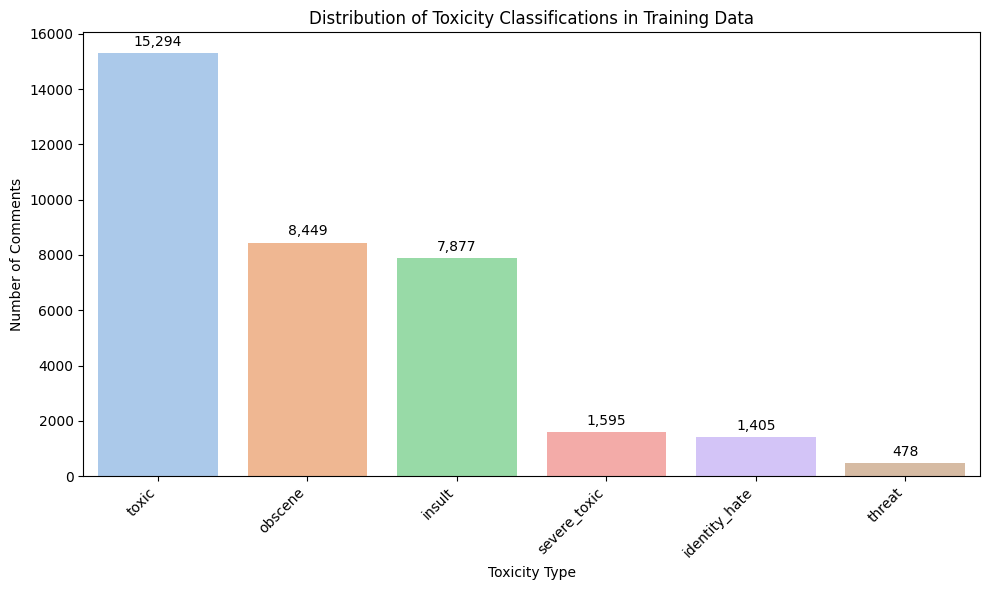

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define toxic_counts_dict with its previously computed values to avoid FileNotFoundError
toxic_counts_series = toxic_counts_series.sort_values(ascending = False)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x=toxic_counts_series.index, y=toxic_counts_series.values, palette='pastel')


for i, value in enumerate(toxic_counts_series.values):
    ax.text(
        i,                     # x-position
        value + 0.01 * max(toxic_counts_series.values),  # y-position (slightly above bar)
        f'{value:,}',          # formatted label
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Distribution of Toxicity Classifications in Training Data')
plt.xlabel('Toxicity Type')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from google.colab import drive

# Re-mount Google Drive to ensure access to files
drive.mount('/content/drive')

# Re-define project_path and re-load train_df
project_path = '/content/drive/MyDrive/COMP351_Final_Project'
train_df = pd.read_csv(f'{project_path}/train.csv')

# Display the first few rows and shape of the re-loaded DataFrame to confirm successful loading
print("train_df loaded successfully. Shape:", train_df.shape)
print(train_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train_df loaded successfully. Shape: (159571, 8)
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0     

In [ ]:
train_df['comment_length'] = train_df['comment_text'].apply(len)

print("Added 'comment_length' column to train_df. First 5 comments with their lengths:")
print(train_df[['comment_text', 'comment_length']].head())

Added 'comment_length' column to train_df. First 5 comments with their lengths:
                                        comment_text  comment_length
0  Explanation\nWhy the edits made under my usern...             264
1  D'aww! He matches this background colour I'm s...             112
2  Hey man, I'm really not trying to edit war. It...             233
3  "\nMore\nI can't make any real suggestions on ...             622
4  You, sir, are my hero. Any chance you remember...              67


In [ ]:
#For the EDA cell below
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_df["any_toxic"] = train_df[label_cols].max(axis=1)

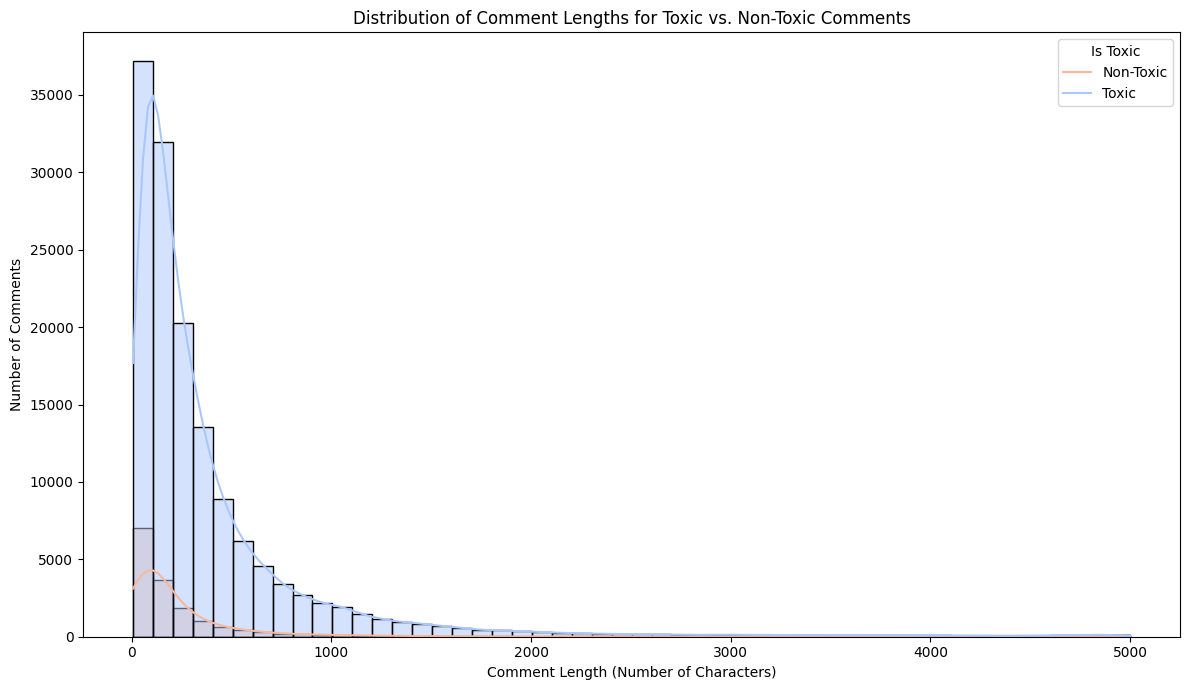

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.histplot(data=train_df, x='comment_length', hue='any_toxic', kde=True, bins=50, palette='coolwarm') #Changed hue='any_toxic' from is_toxic
plt.title('Distribution of Comment Lengths for Toxic vs. Non-Toxic Comments')
plt.xlabel('Comment Length (Number of Characters)')
plt.ylabel('Number of Comments')
plt.legend(title='Is Toxic', labels=['Non-Toxic', 'Toxic'])
plt.tight_layout()
plt.show()

In [ ]:
train_df["clean_text"] = train_df["comment_text"].str.lower()
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(r"<.*?>", "", x))
train_df["clean_text"] = train_df["clean_text"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", " ", x))
train_df["clean_text"] = train_df["clean_text"].apply(
    lambda text: " ".join(
        [w for w in text.split() if w.isalpha() and w not in stop_words and len(w) > 1]
    )
)

In [ ]:
train_df["text_len"] = train_df["clean_text"].apply(lambda x: len(x.split()))
train_df["text_len"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])


,text_len
count,159571.000000
mean,34.001730
std,52.941085
min,0.000000
50%,18.000000
75%,37.000000
90%,76.000000
95%,115.000000
99%,296.000000
max,1250.000000


# ---------------------------------------------------------------------------------